# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (9.0, 6.0)
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def f(eta):
    return eta**2*(eta-1)**2

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

* Derivative of given, $f(\eta) = \eta^2(\eta-1)^2$, double well potential function is: 
$$ f'(\eta) = 2 \eta (\eta-1)^2 + \eta^2 2 (\eta-1) \\
= 4 \eta^3 -6 \eta^2 +2 \eta$$

In [3]:
# Step 1.1 : Fill in with the derivative of the double well potential function

def F(eta):
    '''Derivative of f(eta)'''
    return 4*eta**3 - 6*eta**2 + 2*eta

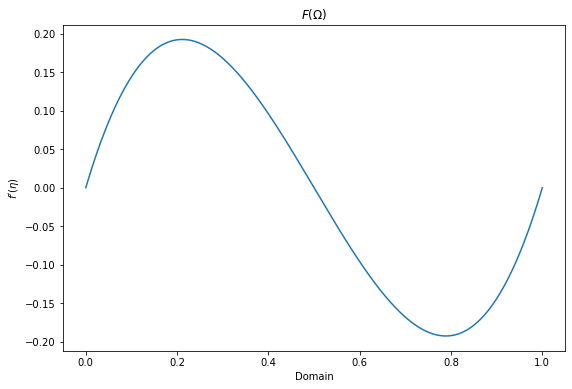

In [4]:
# plot of the derivative of double well potential function
N = 1025
x = linspace(0,1, N)
plt.title("$F(\Omega)$")
plt.xlabel("Domain")
plt.ylabel("$f'(\eta)$")
_ = plot(x,F(x))

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

In [5]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    # Insert here what was in notebook 9
    ''' Compute the piecewise polynomial objects (taken from notebook 09)'''
    
    basis = []
    dbasis = []
    
    for i in range(len(support_points)):
        c = support_points*0
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        
        basis.append(bi)
        dbasis.append(bi.derivative(1))

    # after you have computed the basis, return it
    # return basis, 
    # it is convinient to return the dbasis to use in solve_allen_cahan for computing matrices M,K
    return basis, dbasis

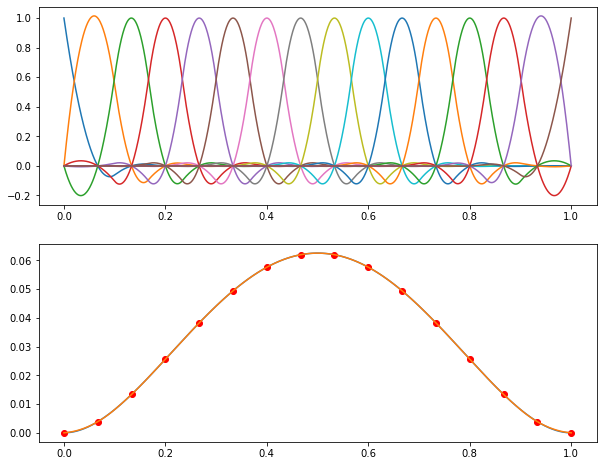

In [6]:
# plot the basis functions

ndofs = 16
degree = 2

support_points = linspace(0,1, ndofs)

B = zeros((N,ndofs))

basis_func , _ = compute_basis_functions(support_points,degree)

for i in range(len(support_points)):
    B[:,i] = basis_func[i](x)


fig, axs = plt.subplots(2,figsize = (10,8))

# basis functions (degree 2)
_ = axs[0].plot(x,B)
# piecewise polynomial interpolation of our function
_ = axs[1].plot(x, f(x))
_ = axs[1].plot(support_points, f(support_points), 'ro')
_ = axs[1].plot(x, B.dot(f(support_points)))

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

In [7]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e., unique(basis.x)), and 
    create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval. Put all of these 
    together, and return the result'''
    
    intervals = unique(basis[0].x) # Make sure every interval border is taken only once
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points+1) # and make sure we can integrate exactly the product of two basis functions
    qp = (qp+1)/2 # rescaling
    w /= 2
    
    # Now replicate these points and weights in all the intervals
    h = diff(intervals)
    global_quadrature = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    # return global_quadrature, global_weights
    return global_quadrature, global_weights

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

In [8]:
# Step 1.4

def compute_system_matrices(basis, dbasis, global_quadrature, global_weights):
    '''Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them'''
    Bq = array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    M = einsum('qi, q, qj', Bq, global_weights, Bq)
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    
    # return M, K
    return M, K

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

In [9]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta, containing the solution at all points
    ''' Forward Euler solution'''
    
    support_points = linspace(0,1, ndofs)
    basis, dbasis = compute_basis_functions(support_points,degree)
    Q, W = compute_global_quadrature(basis,degree+1)
    M, K = compute_system_matrices(basis, dbasis, Q, W)
    
    A = M + (dt*eps**2) * K 
    steps = int(1/dt)
    time_interval = [i*dt for i in range(steps+1)]
    eta = zeros((len(time_interval),ndofs))             # the matrix that will store the results
    eta[0,:] = eta_k = eta_0_function(support_points)           # initial values
    for t in range(1,len(time_interval)):
        # b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
        b = M.dot((eta_k - dt*F(eta_k)))
        eta_k = linalg.solve(A,b)
        eta[t,:] = eta_k
        
    return eta, basis

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

In [10]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    x = linspace(0,1,resolution)
    B = zeros((resolution, len(basis)))
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    n_t = shape(eta)[0]
    t = ['t ='+str(round((i/(n_t-1)),2)) for i in range(n_t)]
    
    for eta, label in zip(eta[::-stride], t[::-stride]):
        plot(x,eta.dot(B.T), label = label)
    
    _ = legend()
    _ = title("Solution")
    _ = xlabel('$x$')
    _ = ylabel('$y$')

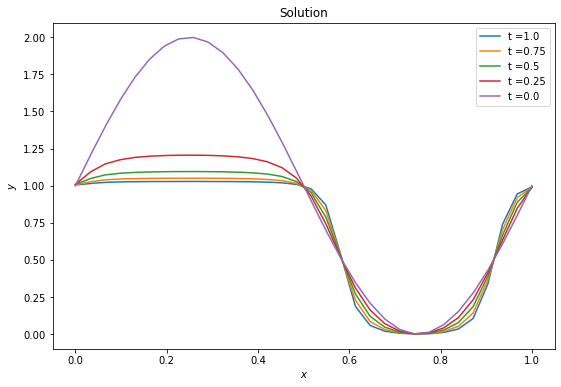

In [11]:
# initial function
def eta_0(x):
    return sin(2*pi*x)+1

eta, basis = solve_allen_cahan(eta_0,eps = 0.01, dt=0.025, ndofs=32, degree=1)
plot_solution(eta,basis,stride=10,resolution=1025)

## Step 3

Solve the problem for all combinations of

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

*Clarifying the plot structures:*

Belove you can find the plots for all combinations. Totally, there are 40 subplots and each subplot has three lines which represent the degree. When you move to the right, $ndofs$ increases and when you move to the belove $dt$ decreases.

In [12]:
eps = [0.01, 0.001]

ndofs = [16, 32, 64, 128]

degree = [1, 2, 3]

dt = [0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [13]:
def plot_once(eta_0, eps, ndofs, degree:list, ax, dt, resolution):
    for j in degree:
        eta, basis = solve_allen_cahan(eta_0,eps = eps, dt=dt, ndofs=ndofs, degree=j)
        x = linspace(0,1,resolution)
        B = zeros((resolution, len(basis)))
        for k in range(len(basis)):
            B[:,k] = basis[k](x)
        
        ax.plot(x,eta[-1].dot(B.T),label = "degree = "+str(j))
        ax.legend(loc='lower left')

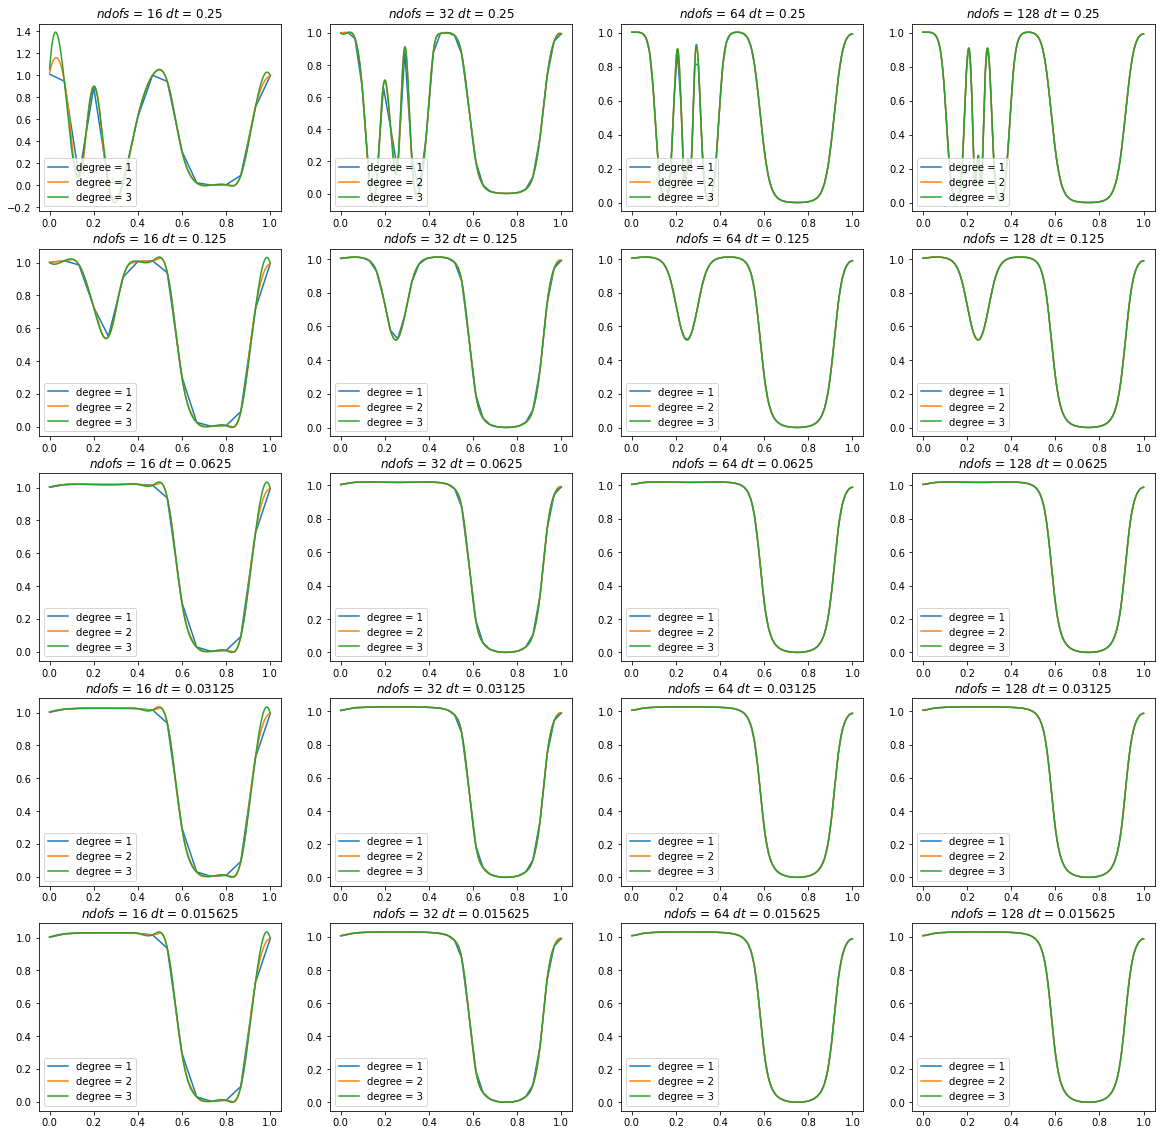

In [14]:
# plotting for eps = 0.01
fig,ax=plt.subplots(nrows=len(dt),ncols=len(ndofs),figsize=(20,20))
for col,n in enumerate(ndofs):
    for row,d in enumerate(dt):
        ax[row,col].set_title("$ndofs$ = "+str(n)+" $dt$ = "+str(d))
        plot_once(eta_0, eps = eps[0], ndofs=n, degree = degree, dt = d,ax = ax[row,col],resolution=1025)

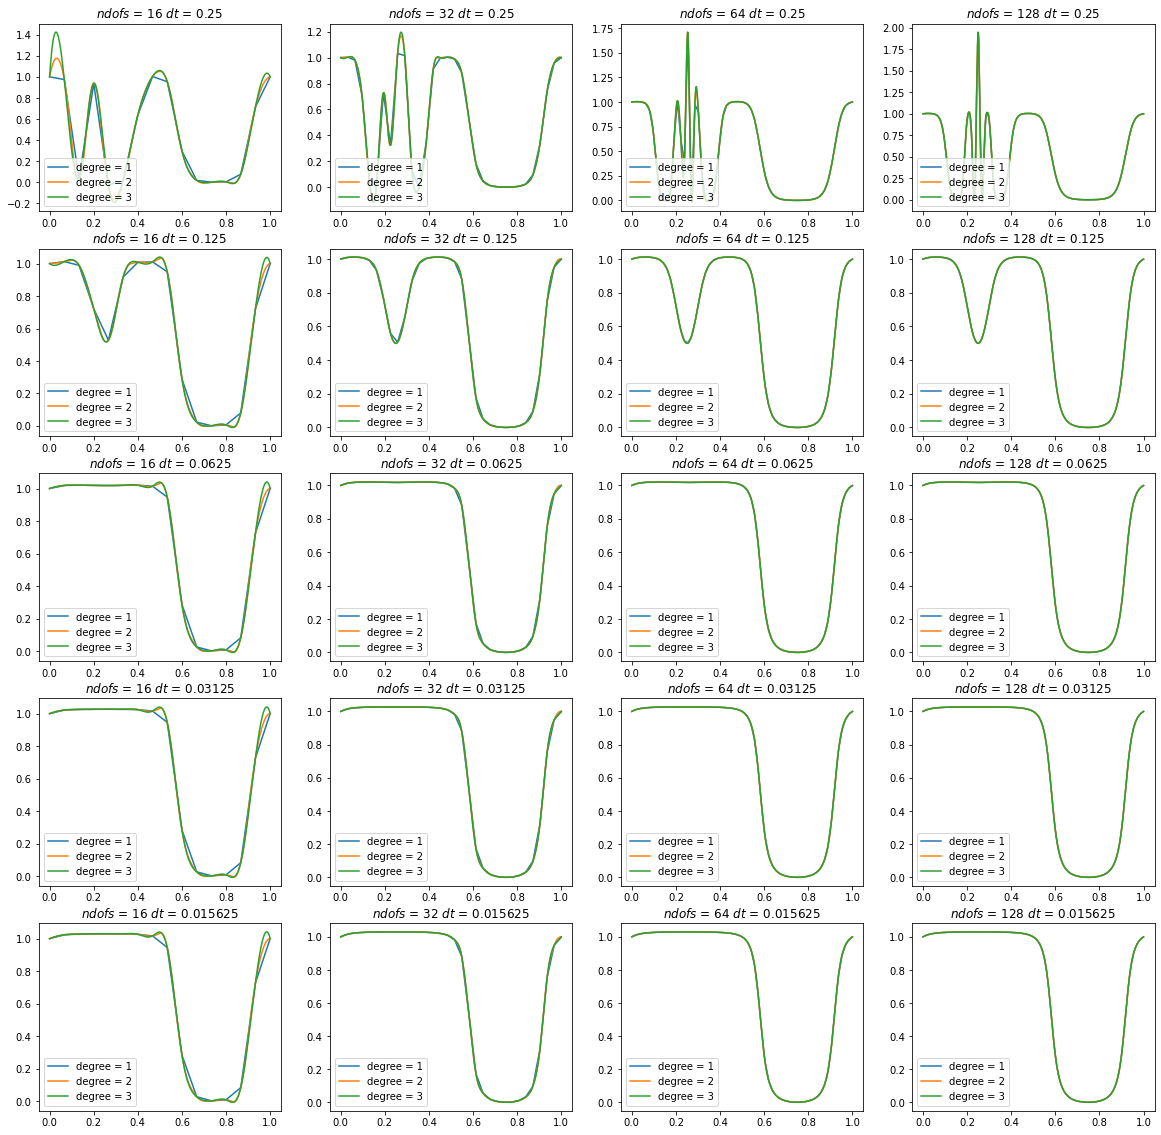

In [15]:
# plotting for eps = 0.001
fig,ax=plt.subplots(nrows=len(dt),ncols=len(ndofs),figsize=(20,20))
for col,n in enumerate(ndofs):
    for row,d in enumerate(dt):
        ax[row,col].set_title("$ndofs$ = "+str(n)+" $dt$ = "+str(d))
        plot_once(eta_0, eps = eps[1], ndofs=n, degree = degree, dt = d,ax = ax[row,col],resolution=1025)

The solution converges when time step is small enough which is consistent with the solution method because Forward Euler is conditionally stable. For example, we can observe abnormal behaviours when $dt$=0.25. Increasing $ndofs$ and $degree$ makes the function smoother.

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

By using the backward euler method we have the following equations:
$$
\frac{\eta_{k+1} - \eta_{k}}{\Delta t} = \varepsilon^2 \eta''_{k+1} - f'(\eta_{k+1}) \\
\eta_{k+1} - \eta_{k} - \Delta t \varepsilon^2 \eta''_{k+1} + \Delta t f'(\eta_{k+1}) = 0
$$

By using the given basis functions, grouping the similar terms and taking all the variables to left hand side we have the following equation:

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} - \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_{k+1})\big) = 0
$$

By using the same matrix notation $A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big)$ we have:

$$
A_{ij} \eta^j_{k+1} - M_{ij} \eta^j_{k} + \Delta t M_{ij} f'(\eta_{k+1}) = 0
$$

So for each step we have to find $\eta^j_{k+1}$ which makes above equation 0. To do this, `scipy` method [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) is used which `returns the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.`


In [16]:
def solve_backward(eta_0_function, eps, dt, ndofs, degree):
    ''' Backward Euler solution'''
    
    support_points = linspace(0,1, ndofs)
    basis, dbasis = compute_basis_functions(support_points,degree)
    Q, W = compute_global_quadrature(basis,degree+1)
    M, K = compute_system_matrices(basis, dbasis, Q, W)
    A = M + (dt*eps**2) * K 
    
    steps = int(1/dt)
    time_interval = [i*dt for i in range(steps+1)]
    
    eta = zeros((len(time_interval),ndofs))  
    eta_k = eta_0_function(support_points)
    eta[0,:] = eta_k
    
    for t in range(1,len(time_interval)):
        eta_k = scipy.optimize.fsolve(lambda x: A.dot(x) - M.dot(eta_k) + dt*M.dot(F(x)),eta_k)
        eta[t,:] = eta_k
        
    return eta, basis    

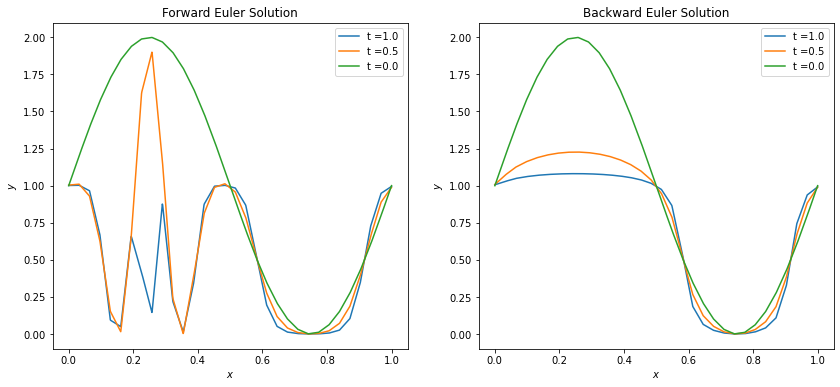

In [17]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
eta, basis = solve_allen_cahan(eta_0,eps = 0.01, dt=0.25, ndofs=32, degree=1)
_ = plot_solution(eta,basis,stride=2,resolution=1025)
_ = title("Forward Euler Solution")

plt.subplot(1, 2, 2)
eta, basis = solve_backward(eta_0,eps = 0.01, dt=0.25, ndofs=32, degree=1)
_ = plot_solution(eta,basis,stride=2,resolution=1025)
_ = title("Backward Euler Solution")

Unlike forward euler method, backward euler method is unconditionally stable, including the large time steps. As we can observe from above plot, forward euler method shows abnormal behaviour for `dt = 0.25` whereas backward euler method is stable for any time step value.